In [1]:
import numpy as np
import scipy.fftpack as fftpack
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
%matplotlib inline
font_prop = font_manager.FontProperties(size=16)

# Problem 1: Timmer and Koenig algorithm

The algorithm outlined in Timmer & Koenig 1995 lets you define the shape of your power spectrum (a power law with some slope, a Lorentzian, a sum of a couple Lorentzians and a power law, etc.) then generate the random phases and amplitudes of the Fourier transform to simulate light curves defined by the power spectral shape. This is a great simulation tool to have in your back pocket (or, "maybe useful someday" github repo).

#### Define some basic parameters for the power spectrum and resultant light curve

In [2]:
n_bins = 8192  ## number of total frequency bins in a FT segment; same as number of time bins in the light curve
dt = 1./16.  # time resolution of the output light curve
df = 1. / dt / n_bins

## 1a. Make an array of Fourier frequencies
Yes you can do this with scipy, but the order of frequencies in a T&K power spectrum is different than what you'd get by default from a standard FFT of a light curve.
You want the zero frequency to be in the middle (at index n_bins/2) of the frequency array. The positive frequencies should have two more indices than the negative frequencies, because of the zero frequency and nyquist frequency. You can either do this with `np.arange` or with special options in `fftpack.fftfreq`.

In [3]:
freqs = np.arange(float(-n_bins/2)+1, float(n_bins/2)+1) * df
pos_freq = freqs[np.where(freqs >= 0)]
## Positive should have 2 more than negative, 
## because of the 0 freq and the nyquist freq
neg_freq = freqs[np.where(freqs < 0)]
nyquist = pos_freq[-1]
len_pos = len(pos_freq)

## 1b. Define a Lorentzian function and power law function for the shape of the power spectrum

In [4]:
def lorentzian(v, v_0, gamma):
    """ Gives a Lorentzian centered on v_0 with a FWHM of gamma """
    numerator = gamma / (np.pi * 2.0)
    denominator = (v - v_0) ** 2 + (1.0/2.0 * gamma) ** 2
    L = numerator / denominator
    return L

def powerlaw(v, beta):
    """Gives a powerlaw of (1/v)^-beta """
    pl = np.zeros(len(v))
    pl[1:] = v[1:] ** (-beta)
    pl[0] = np.inf
    return pl

## Now the T&K algorithm. I've transcribed the 'recipe' section of the T&K95 paper, which you will convert to lines of code. 

## 1c. Choose a power spectrum $S(\nu)$. 
We will use a sum of one Lorentzians (a QPO with a centroid frequency of 0.5 Hz and a FWHM of 0.01 Hz), and a Poisson-noise power law. The QPO should be 100 times larger amplitude than the power-law.

In [5]:
## For a Lorentzian-shaped QPO
qpo_v0 = 0.5  ## Centroid frequency of QPO
qpo_fwhm = 0.01  ## FWHM of QPO
## Relative scale factors
qpo_scale = 100. 
noise_scale = 1
## Putting it together
power_shape = qpo_scale * lorentzian(pos_freq, qpo_v0, qpo_fwhm) + \
              noise_scale * powerlaw(pos_freq, 0)

## 1d.  For each Fourier frequency $\nu_i$ draw two gaussian-distributed random numbers, multiply them by $$\sqrt{\frac{1}{2}S(\nu_i)}$$ and use the result as the real and imaginary part of the Fourier transform $F$ of the desired data.
In the case of an even number of data points, for reason of symmetry $F(\nu_{Nyquist})$ is always real. Thus only one gaussian distributed random number has to be drawn.

In [6]:
np.random.seed(3)
rand_r = np.random.standard_normal(len_pos)
rand_i = np.random.standard_normal(len_pos-1)
rand_i = np.append(rand_i, 0.0) # because the nyquist frequency should only have a real value

## Creating the real and imaginary values from the lists of random numbers and the frequencies
r_values = rand_r * np.sqrt(0.5 * power_shape)
i_values = rand_i * np.sqrt(0.5 * power_shape)
r_values[np.where(pos_freq == 0)] = 0
i_values[np.where(pos_freq == 0)] = 0

## 1e. To obtain a real valued time series, choose the Fourier components for the negative frequencies according to $F(-\nu_i)=F*(\nu_i)$ where the asterisk denotes complex conjugation. 

Append to make one fourier transform array. Check that your T&K fourier transform has length `n_bins`. Again, for this algorithm, the zero Fourier frequency is in the middle of the array, the negative Fourier frequencies are in the first half, and the positive Fourier frequencies are in the second half.

In [7]:
FT_pos = r_values + i_values*1j
FT_neg = np.conj(FT_pos[1:-1]) 
FT_neg = FT_neg[::-1]  ## Need to flip direction of the negative frequency FT values so that they match up correctly
FT = np.append(FT_pos, FT_neg)

## 1f. Obtain the time series by backward Fourier transformation of $F(\nu)$ from the frequency domain to the time domain.

Note: I usually use `.real` after an iFFT to get rid of any lingering 1e-10 imaginary factors.

In [8]:
lc = fftpack.ifft(FT).real

Congratulations! 
## 1g. Plot the power spectrum of your FT (only the positive frequencies) next to the light curve it makes. 
Remember: $$P(\nu_i)=|F(\nu_i)|^2$$

In [9]:
pos_power = np.absolute(FT_pos)**2

You'll want to change the x scale of your light curve plot to be like 20 seconds in length, and only use the positive Fourier frequencies when plotting the power spectrum.

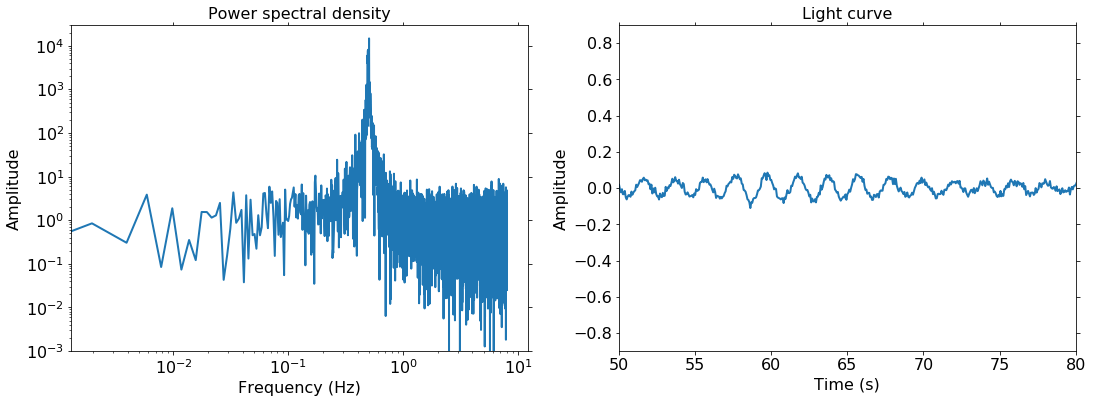

In [10]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,6))
ax1.plot(pos_freq, pos_power, lw=2)
ax1.set_xscale('log')
ax1.set_yscale('log')
# ax1.set_xlim(pos_freq[1],2)
ax1.set_ylim(1e-3, 3e4)
ax1.set_xlabel("Frequency (Hz)", fontproperties=font_prop)
ax1.set_ylabel("Amplitude", fontproperties=font_prop)
ax1.set_title("Power spectral density", fontproperties=font_prop)
ax1.tick_params(axis='both', which='major', labelsize=16, 
               top=True, right=True, bottom=True, left=True)
ax2.plot(np.arange(0,n_bins*dt, dt), lc, lw=2)
# ax2.set_xlim(0,256)
ax2.set_xlim(50,80)
ax2.set_ylim(-0.9,0.9)
ax2.set_title("Light curve", fontproperties=font_prop)
ax2.set_xlabel("Time (s)", fontproperties=font_prop)
ax2.set_ylabel("Amplitude", fontproperties=font_prop)
ax2.tick_params(axis='both', which='major', labelsize=16, 
               top=True, right=True, bottom=True, left=True)
plt.show()

Yay!

## 1h. Play around with your new-found simulation powers (haha, it's a pun!) 
Make more power spectra with different features -- try at least 5 or 6, and plot each of them next to the corresponding light curve. Try red noise, flicker noise, a few broad Lorentzians at lower frequency, multiple QPOs, a delta function, etc. 

Here are some other functions you can use to define shapes of power spectra. This exercise is to help build your intuition of what a time signal looks like in the Fourier domain and vice-versa.

In [11]:
def gaussian(v, mean, std_dev):
    """
    Gives a Gaussian with a mean of mean and a standard deviation of std_dev
    FWHM = 2 * np.sqrt(2 * np.log(2))*std_dev
    """
    exp_numerator = -(v - mean)**2
    exp_denominator = 2 * std_dev**2
    G = np.exp(exp_numerator / exp_denominator)
    return G

def powerlaw_expdecay(v, beta, alpha):
    """Gives a powerlaw of (1/v)^-beta with an exponential decay e^{-alpha*v} """
    pl_exp = np.where(v != 0, (1.0 / v) ** beta * np.exp(-alpha * v), np.inf) 
    return pl_exp

def broken_powerlaw(v, v_b, beta_1, beta_2):
    """Gives two powerlaws, (1/v)^-beta_1 and (1/v)^-beta_2 
       that cross over at break frequency v_b."""
    c = v_b ** (-beta_1 + beta_2)  ## scale factor so that they're equal at the break frequency
    pl_1 = v[np.where(v <= v_b)] ** (-beta_1)
    pl_2 = c * v[np.where(v > v_b)] ** (-beta_2)
    pl = np.append(pl_1, pl_2)
    return pl

# 2. More realistic simulation with T&K
Now you're able to simulate the power spectrum of a single segment of a light curve. However, as you learned this morning, we usually use multiple (~50+) segments of a light curve, take the power spectrum of each segment, and average them together.

## 2a. Turn the code from 1d to 1e into a function `make_TK_seg`
Make it so that you can give a different random seed to each segment.

In [12]:
def make_TK_seg(pos_freq, power_shape, seed_num=0):
    np.random.seed(seed_num)
    rand_r = np.random.standard_normal(len_pos)
    rand_i = np.random.standard_normal(len_pos-1)
    rand_i = np.append(rand_i, 0.0) # because the nyquist frequency should only have a real value

    ## Creating the real and imaginary values from the lists of random numbers and the frequencies
    r_values = rand_r * np.sqrt(0.5 * power_shape)
    i_values = rand_i * np.sqrt(0.5 * power_shape)
    r_values[np.where(pos_freq == 0)] = 0
    i_values[np.where(pos_freq == 0)] = 0

    ## Combining to make the Fourier transform
    FT_pos = r_values + i_values*1j
    FT_neg = np.conj(FT_pos[1:-1]) 
    FT_neg = FT_neg[::-1]  ## Need to flip direction of the negative frequency FT values so that they match up correctly
    FT = np.append(FT_pos, FT_neg)
    return FT

## 2b. Make the Fourier transform for a given power shape (as in Problem 1)
Use a Lorentzian QPO + Poisson noise power shape at a centroid frequency of 0.5 Hz and a full width at half maximum (FWHM) of 0.01 Hz. Make the QPO 100 time stronger than the Poisson noise power-law.

In [13]:
## For a Lorentzian-shaped QPO
qpo_v0 = 0.5  ## Centroid frequency of QPO
qpo_fwhm = 0.01  ## FWHM of QPO
power_shape = 100*lorentzian(pos_freq, qpo_v0, qpo_fwhm) + powerlaw(pos_freq, 0)

## 2c. Put `make_TK_seg` in a loop to do for 50 segments. 
Make an array of integers that can be your random gaussian seed for the TK algorithm (otherwise, you run the risk of creating the exact same Fourier transform every time, and that will be boring).

Keep a running average of the power spectrum of each segment (like we did this morning in problem 2).

In [14]:
psd_avg = np.zeros(n_bins)
nseg = 50

ft_seed = np.random.randint(low=0, high=nseg*3, size=nseg)

for idx in range(0, nseg):
    ## Making FT with specific shape in Fourier domain
    FT = make_TK_seg(pos_freq, power_shape, seed_num=ft_seed[idx])
    psd_seg = np.abs(FT)**2
    psd_avg += psd_seg

psd_avg /= nseg

## 2d. Compute the error on the average power
The error on the power at index $i$ is
$$ \delta P_i = \frac{P_i}{\sqrt{M}} $$
where `M` is the number of segments averaged together.

In [15]:
err_psd = psd_avg / np.sqrt(nseg)

## 2e. Use the re-binning algorithm described in the morning's workbook to re-bin the power spectrum by a factor of 1.05.

In [16]:
def rebin(freq, power, err_power, rebin_factor=1.05):
    """
    Re-bin the power spectrum in frequency space by some re-binning factor
    (rebin_factor > 1). This is sometimes called 'geometric re-binning' or 
    'logarithmic re-binning', as opposed to linear re-binning 
    (e.g., grouping by 2)

    Parameters
    ----------
    freq : np.array of floats
        1-D array of the Fourier frequencies.

    power : np.array of floats
        1-D array of the power at each Fourier frequency, with any/arbitrary
        normalization.

    err_power : np.array of floats
        1-D array of the error on the power at each Fourier frequency, with the
        same normalization as the power.

    rebin_factor : float
        The factor by which the data are geometrically re-binned.

    Returns
    -------
    rb_freq : np.array of floats
        1-D array of the re-binned Fourier frequencies.

    rb_power : np.array of floats
        1-D array of the power at the re-binned Fourier frequencies, with the
        same normalization as the input power array.

    rb_err : np.array of floats
        1-D array of the error on the power at the re-binned Fourier
        frequencies, with the same normalization as the input error on power.
    """
    assert rebin_factor >= 1.0

    rb_power = np.asarray([])  # Array of re-binned power
    rb_freq = np.asarray([])   # Array of re-binned frequencies
    rb_err = np.asarray([])    # Array of error in re-binned power
    real_index = 1.0           # The unrounded next index in power
    int_index = 1              # The int of real_index, added to current_m every iteration
    current_m = 1              # Current index in power
    prev_m = 0                 # Previous index m

    ## Loop through the length of the array power, new bin by new bin, to
    ## compute the average power and frequency of that new geometric bin.
    while current_m < len(power):

        ## Determine the range of indices this specific geometric bin covers
        bin_range = np.absolute(current_m - prev_m)
        ## Want mean power of data points contained within one geometric bin
        bin_power = np.mean(power[prev_m:current_m,])
        ## Compute error in bin
        err_bin_power2 = np.sqrt(np.sum(err_power[prev_m:current_m] ** 2)) / \
            float(bin_range)
        ## Compute the mean frequency of a geometric bin
        bin_freq = np.mean(freq[prev_m:current_m])
        ## Append values to arrays
        rb_power = np.append(rb_power, bin_power)
        rb_freq = np.append(rb_freq, bin_freq)
        rb_err = np.append(rb_err, err_bin_power2)

        ## Increment for the next iteration of the loop
        ## Since the for-loop goes from prev_m to current_m-1 (since that's how
        ## the range function and array slicing works) it's ok that we set
        ## prev_m = current_m here for the next round. This will not cause any
        ## double-counting bins or skipping bins.
        prev_m = current_m
        real_index *= rebin_factor
        int_index = int(round(real_index))
        current_m += int_index

    return rb_freq, rb_power, rb_err
freqs = fftpack.fftfreq(n_bins, d=dt)
nyq_idx = int(n_bins/2)

rb_freq, rb_pow, rb_err = rebin(freqs[0:nyq_idx], psd_avg[0:nyq_idx], err_psd[0:nyq_idx], rebin_factor=1.05)

# Plot

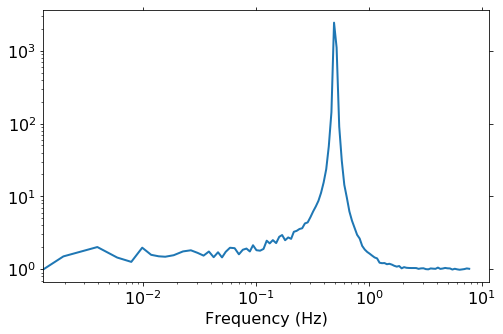

In [17]:
fig, ax = plt.subplots(1,1, figsize=(8,5))
ax.plot(rb_freq, rb_pow, linewidth=2.0)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'Frequency (Hz)', fontproperties=font_prop)
ax.tick_params(axis='x', labelsize=16, bottom=True, top=True, 
               labelbottom=True, labeltop=False)
ax.tick_params(axis='y', labelsize=16, left=True, right=True, 
               labelleft=True, labelright=False)
plt.show()

## 2f. Re-do 2b through the plot above but slightly changing the power spectrum shape in each segment. 
Maybe you change the centroid frequency of the QPO, or the normalizing factors between the two components, or the slope of the power-law.

# Bonus problems:

## 1. Use a different definition of the Lorentzian (below) to make a power spectrum. 
Follow the same procedure. Start off with just one segment. Use the rms as the normalizing factor.

## 2. Using what you learned about data visualization earlier this week, turn the plots in this notebook (and the QPO one, if you're ambitious) into clear and easy-to-digest, publication-ready plots.

In [18]:
def lorentz_q(v, v_peak, q, rms):  
    """ 
    Form of the Lorentzian function defined in terms of 
    peak frequency v_peak and quality factor q
    q = v_peak / fwhm
    with the integrated rms of the QPO as the normalizing factor.
    e.g. see Pottschmidt et al. 2003, A&A, 407, 1039 for more info
    """
    f_res = v_peak / np.sqrt(1.0+(1.0/(4.0*q**2)))
    r = rms / np.sqrt(0.5-np.arctan(-2.0*q)/np.pi)
    lorentz = ((1/np.pi)*2*r**2*q*f_res) / (f_res**2+(4*q**2*(v-f_res)**2))
    return lorentz